In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, welch
%matplotlib inline

In [7]:
class PhaseTimeStream:
    """ A time series containing photon pulses.
    Attributes:
     - fs: float, sample rate [Hz]
     - ts: float, sample time [uSec]
     - tvec: 1D np.array, time vector [Sec]
     - points: number of samples [None]
     - raw_phase_data: phase timestream
     - photon_arrivals: boolean 1D np.array, whether or not a photon arrived in that time step."""
    
    def __init__(self, fs, ts, seed = 2):
        self.fs = fs
        self.ts = ts
        self.points = int(self.ts*1e-6*self.fs)
        self.tvec = np.arange(0,self.points)/self.fs # J: now I think fs is the real sample rate
        self.phase_data = np.zeros(self.points)
        self.rng = np.random.default_rng(seed=seed)
        
    def plot_phasetime(self, data):
        plt.plot(self.tvec*1e6, data)
        plt.xlabel('time (usec)')
        plt.ylabel('phase (radians?)')
        
    def gen_pulse(self, tr=4,tf=30):
        """ pulse with tr rise time in usec and tf fall time in usec."""
        tp = np.linspace(0,10*tf,int(10*tf+1)) # pulse duration
        self.pulse = -tf * (np.exp(-tp / tf) - np.exp(-(tp) / tr)) / (tf - tr)
        return(self.pulse)

    def plot_pulse(self):
        plt.plot(self.pulse)
        plt.xlabel('Time (usec)')
        plt.ylabel('Phase (radians?)')
        
    def gen_photon_arrivals(self, cps = 500):
        """ genetrate boolean list corresponding to poisson-distributed photon arrival events.
        Inputs:
        - cps: int, photon co
        unts per second.
        """
        photon_events = self.rng.poisson(cps/self.fs,self.tvec.shape[0])
        self.photon_arrivals = np.array(photon_events, dtype=bool)
        if sum(photon_events) > sum(self.photon_arrivals):
            print('Warning: More than 1 photon arriving per time step. Recommendation: Lower the count rate.')
        if sum(photon_events) == 0:
            print("Warning: No photons arrived. :'(")
        self.total_photons = sum(self.photon_arrivals)
        return(self.photon_arrivals)
    
    def populate_photons(self):
        for i in range(self.phase_data.size):
            if self.photon_arrivals[i]:
                self.phase_data[i:i+self.pulse.shape[0]]=self.pulse
        return(self.phase_data)
    
    def trigger(self, threshold = -0.2, holdoff = 10):
        """ threshold = phase value one must exceed to trigger
        holdoff: samples to wait before triggering again."""
        
        all_trig =(np.diff(phase_data.phase_data, prepend=0)>0) & (phase_data.phase_data < threshold)
        trig = all_trig
        # impose holdoff
        for i in range(all_trig.size):
            if all_trig[i]:
                trig[i+1:i+1+holdoff]=0
        self.trig = trig
        self.total_triggers = sum(self.trig)
        return(self.trig)
        
    def plot_triggers(self, trig):
        plt.plot(self.tvec*1e6, self.phase_data)
        plt.plot(self.tvec[trig]*1e6, self.phase_data[trig],'.')
        plt.xlabel('time (us)')
        plt.ylabel('phase (radians)')
        #plt.xticks(rotation = 45)
    
    def record_energies(self):
        self.photon_energies = self.phase_data[self.trig]
        return(self.photon_energies)
    
    def energy_histogram(self):
        plt.hist(self.photon_energies, bins = self.photon_energies.size)
        plt.xlabel('Phase peak (need to change this to energy?)')
        plt.ylabel('counts')
        
    def gen_amp_noise(self, snr):
        """ Flat PSD, white-noise generated from voltage fluctuations"""
        a_noise = 10**((20*np.log10(1/np.sqrt(2)) - snr)/10); #input dBm of noise
        noise = np.sqrt(a_noise)*self.rng.normal(size=self.points)
        self.amp_noise = noise
        
    def plot_psd(self, data, fres = 1e3, **kwargs):
        default = {'fs': self.fs, 'nperseg': self.fs/fres}
        default.update(kwargs)
        f, psd = welch(data, **default)
        plt.semilogx(f,10*np.log10(psd))
        plt.xlabel(f'Frequency [Hz] ({fres*1e-3:g} kHz resolution)')
        plt.ylabel('dB/Hz')
        plt.grid()
        plt.title('Power Spectral Density')
        # add axis later (include res)
        
    def inject_amp_noise(self):
        self.phase_data +=self.amp_noise

In [8]:
# Generate a phase time stream
phase_data = PhaseTimeStream(fs = 2e6, ts = 20e3)

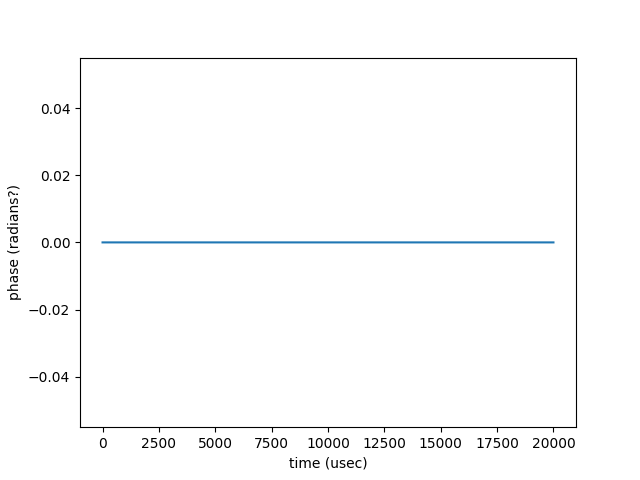

In [9]:
# Plot the raw data
phase_data.plot_phasetime(phase_data.phase_data)

In [14]:
plt.plot(np.linspace(0,5,6))
#plt.ion()
#plt.show()

In [6]:
# Define a photon pulse
phase_data.gen_pulse();

In [8]:
# Plot the pulse
phase_data.plot_pulse()

In [123]:
# Generate photon arrival times
phase_data.gen_photon_arrivals(500)

array([False, False, False, ..., False, False, False])

In [124]:
# Verify how many photons we got
phase_data.total_photons

12

In [125]:
# Populate phase data with photon pulses
phase_data.populate_photons()

array([0., 0., 0., ..., 0., 0., 0.])

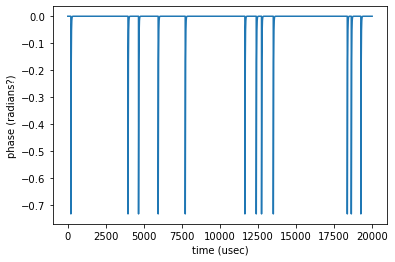

In [126]:
# Plot new phase data
phase_data.plot_phasetime(phase_data.phase_data)

In [127]:
# Trigger on photons
phase_data.trigger(threshold=-0.6, holdoff=10)

array([False, False, False, ..., False, False, False])

In [128]:
# Count Triggers
print('Photons:', phase_data.total_photons, 'Triggers:',phase_data.total_triggers)

Photons: 12 Triggers: 12


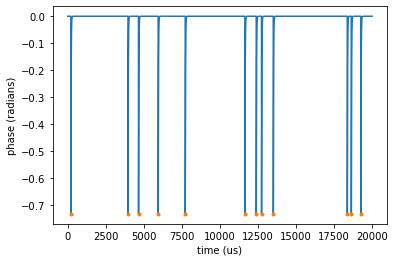

In [129]:
# Plot trigger events
phase_data.plot_triggers(phase_data.trig)

In [130]:
# Record triggered values
phase_data.record_energies()

array([-0.73205344, -0.73205344, -0.73205344, -0.73205344, -0.73205344,
       -0.73205344, -0.73205344, -0.73205344, -0.73205344, -0.73205344,
       -0.73205344, -0.73205344])

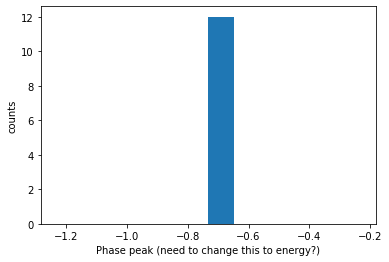

In [131]:
# Plot histogram of "energies"
phase_data.energy_histogram()

# Add Noise

In [132]:
phase_data.gen_amp_noise(10)

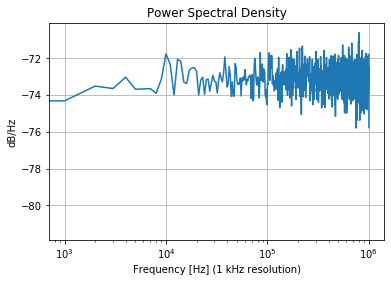

In [133]:
phase_data.plot_psd(phase_data.amp_noise)

In [134]:
phase_data.inject_amp_noise()

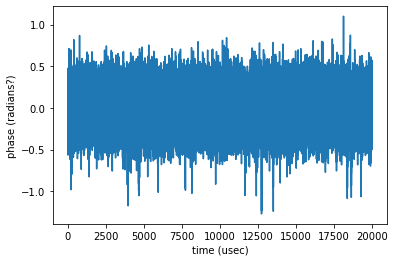

In [135]:
# Plot new phase data
phase_data.plot_phasetime(phase_data.phase_data)

In [136]:
# Trigger on photons
phase_data.trigger(threshold=-0.6, holdoff=10)

array([False, False, False, ..., False, False, False])

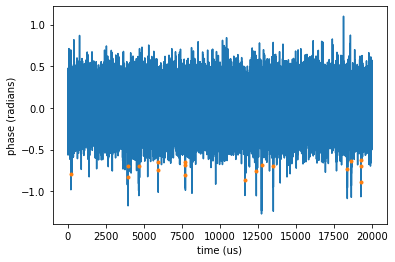

In [137]:
# Plot trigger events
phase_data.plot_triggers(phase_data.trig)

In [138]:
phase_data.record_energies()

array([-0.79683697, -0.69654354, -0.82436379, -0.69967502, -0.65028115,
       -0.7477089 , -0.65148552, -0.69000565, -0.80782827, -0.86739507,
       -0.75448168, -0.68116539, -0.69722059, -0.73244016, -0.64052045,
       -0.6923069 , -0.89046763, -0.63026702])

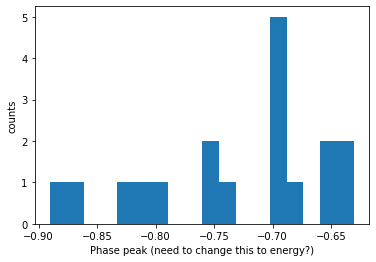

In [139]:
# Plot histogram of "energies"
phase_data.energy_histogram()